# Limpieza inicial de las tablas

In [1]:
import re
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# ---------------------------
# FUNCIONES AUXILIARES
# ---------------------------
def limpiar_dataframe(df):
    """Estandariza nombres de columnas y reemplaza valores nulos o inválidos."""
    df.columns = [str(col).strip().lower().replace(" ", "_") for col in df.columns]
    df.replace(["s/d", "S/D", "-", "", " "], np.nan, inplace=True)
    return df

def convertir_a_numerico(df, columnas_excluidas=[]):
    for col in df.columns:
        if col not in columnas_excluidas:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# ---------------------------
# CARGA DE DATOS
# ---------------------------

# 1. Focos de calor por jurisdicción y año
archivo = os.path.join("datasets","Cantidad de focos de calor registrados por jurisdicción y año.xlsx")
focos = pd.read_excel(archivo)
focos = limpiar_dataframe(focos)
focos = convertir_a_numerico(focos, columnas_excluidas=["jurisdicción"])

# 2. Incendios por provincia anualizados

archivo = os.path.join("datasets","Incendios por provincia.xlsx")
incendios = pd.read_excel(archivo)
incendios = limpiar_dataframe(incendios)
incendios = convertir_a_numerico(incendios, columnas_excluidas=["jurisdicción", "año"])

# 3. Estadísticas normales (múltiples hojas)
archivo = os.path.join("datasets","Estadísticas normales Datos abiertos 1991-2020- TODAS HOJAS.xlsx")
estadisticas = pd.read_excel(archivo, sheet_name=None)
estadisticas_limpias = {}
for hoja, df in estadisticas.items():
    df = limpiar_dataframe(df)
    df = convertir_a_numerico(df)
    estadisticas_limpias[hoja] = df

# 4. Densidad de población por cuenca

archivo = os.path.join("datasets","Densidad de población por cuenca.xlsx")
poblacion = pd.read_excel(archivo)
poblacion = limpiar_dataframe(poblacion)
poblacion = convertir_a_numerico(poblacion, columnas_excluidas=["provincia"])

# 5. Superficie afectada
archivo = os.path.join("datasets","Superficie afectada por incendios reportados, por jurisdicción.xlsx")
superficie_abs = pd.read_excel(archivo, sheet_name="rii_c_hectareas_incendios_prov_")
superficie_pct = pd.read_excel(archivo, sheet_name="Porcentaje de superficie afecta")

superficie_abs = limpiar_dataframe(superficie_abs)
superficie_abs = convertir_a_numerico(superficie_abs, columnas_excluidas=["jurisdicción"])

superficie_pct = limpiar_dataframe(superficie_pct)
superficie_pct["%_suma_de_hectareas"] = pd.to_numeric(superficie_pct["%_suma_de_hectareas"], errors='coerce')

# 6. Supertabla
archivo = os.path.join("datasets","Supertabla.xlsx")
supertabla = pd.read_excel(archivo, sheet_name=None)
df1 = limpiar_dataframe(supertabla['hoja1'])
df2 = limpiar_dataframe(supertabla['hoja2'])

df1 = convertir_a_numerico(df1, columnas_excluidas=["jurisdicción"])
df2 = convertir_a_numerico(df2, columnas_excluidas=["jurisdicción", "combustible"])

# ---------------------------
# REVISIÓN POST-LIMPIEZA
# ---------------------------
print("✔ Limpieza completada.")
print("Dimensiones focos:", focos.shape)
print("Dimensiones incendios:", incendios.shape)
print("Dimensiones población:", poblacion.shape)
print("Dimensiones superficie afectada:", superficie_abs.shape)
print("Dimensiones supertabla_1:", df1.shape)
print("Dimensiones supertabla_2:", df2.shape)


C:\Users\fede4\AppData\Local\Temp\ipykernel_33852\2184513899.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(["s/d", "S/D", "-", "", " "], np.nan, inplace=True)
C:\Users\fede4\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
C:\Users\fede4\AppData\Local\Temp\ipykernel_33852\2184513899.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', Tr

✔ Limpieza completada.
Dimensiones focos: (24, 10)
Dimensiones incendios: (24, 11)
Dimensiones población: (24, 4)
Dimensiones superficie afectada: (24, 11)
Dimensiones supertabla_1: (1352, 6)
Dimensiones supertabla_2: (4650, 4)


# Analisis exploratorio de los Datos

In [3]:
sns.set_theme(style="whitegrid")  # estilo limpio
plt.rcParams["figure.figsize"] = (10, 6)

### Distribucion de focos de calor por jurisdiccion ( En promedio )

C:\Users\fede4\AppData\Local\Temp\ipykernel_33852\1765324587.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=focos_ultimo, x=promedio_anios, y="jurisdicción", palette="Reds_r")


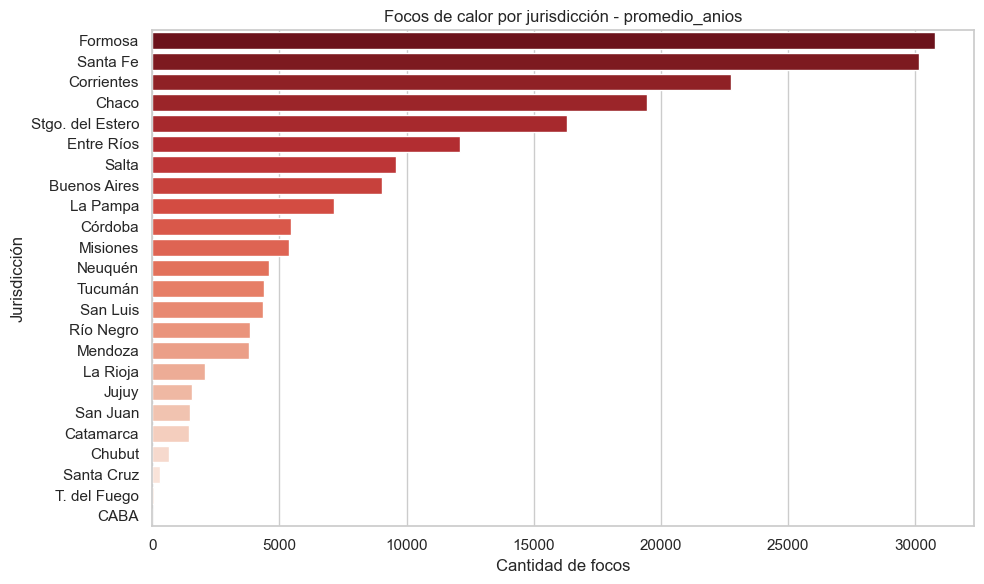

In [4]:
promedio_anios = focos.columns[-1]
focos_ultimo = focos[["jurisdicción", promedio_anios]].sort_values(by=promedio_anios, ascending=False)

plt.figure()
sns.barplot(data=focos_ultimo, x=promedio_anios, y="jurisdicción", palette="Reds_r")
plt.title(f"Focos de calor por jurisdicción - {promedio_anios}")
plt.xlabel("Cantidad de focos")
plt.ylabel("Jurisdicción")
plt.tight_layout()
plt.show()


###  Evolución temporal de focos de calor a nivel nacional

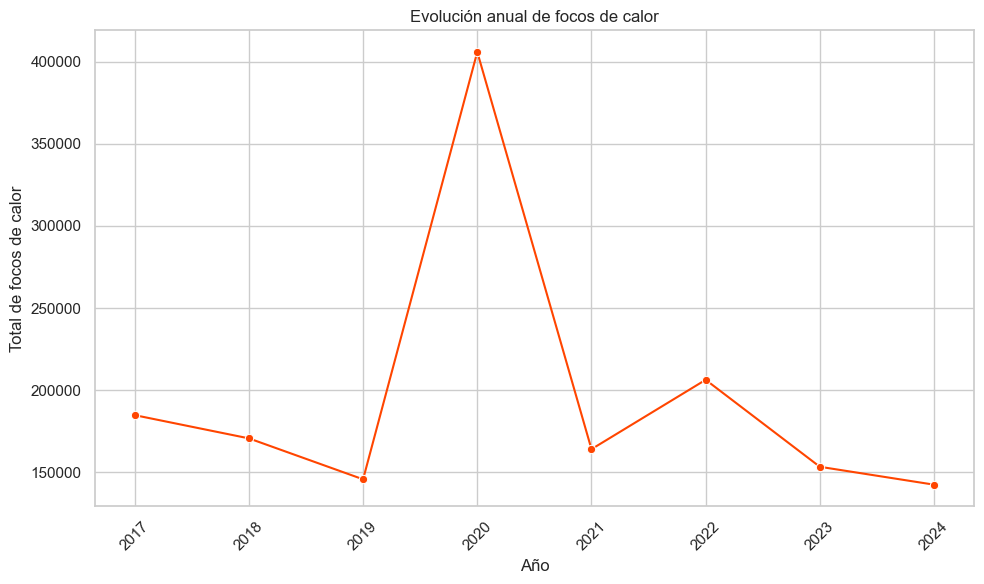

In [5]:
# Excluimos la columna "jurisdicción" y la última columna del DataFrame
columnas_a_sumar = focos.columns[1:-1]  # Seleccionamos todas las columnas excepto la primera ("jurisdicción") y la última("Promedio")

# Sumamos únicamente las columnas numéricas de los años
focos_anual = (
    focos[columnas_a_sumar]  # Nos quedamos solo con las columnas correspondientes a años
    .sum()  # Sumamos los valores por cada año
    .reset_index()  # Convertimos el índice a columna para reestructurar el DataFrame
)

# Renombramos las columnas
focos_anual.columns = ["año", "total_focos"]

# Quitamos el prefijo "año_" en caso de que los nombres contengan este prefijo
focos_anual["año"] = focos_anual["año"].str.replace("año_", "").astype(int)

# Visualizamos los resultados con Seaborn
plt.figure()
sns.lineplot(data=focos_anual, x="año", y="total_focos", marker="o", color="orangered")
plt.title("Evolución anual de focos de calor")
plt.xlabel("Año")
plt.ylabel("Total de focos de calor")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Superficie afectada promedio por jurisdicción

C:\Users\fede4\AppData\Local\Temp\ipykernel_33852\4286718366.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=superficie_media.values, y=superficie_media.index, palette="YlOrBr")


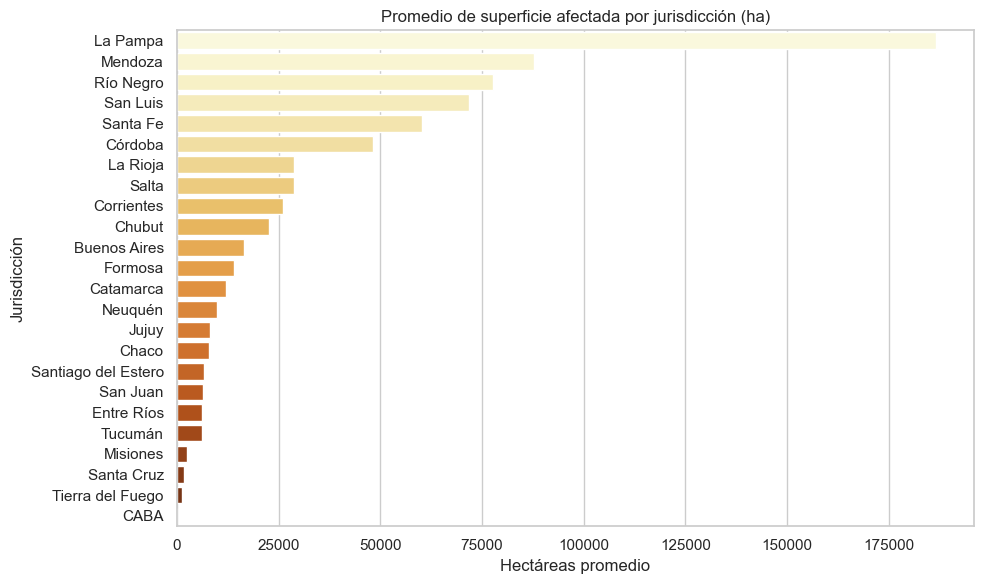

In [6]:
# Verificamos las columnas
columnas_a_promediar = superficie_abs.columns[1:-1]  # Excluimos la primera columna (jurisdicción) y la última (promedio)

# Calculamos de nuevo el promedio de superficie afectada por jurisdicción (si es necesario)
superficie_abs["promedio"] = superficie_abs[columnas_a_promediar].mean(axis=1)

# Seleccionamos la columna 'promedio' para el gráfico
superficie_media = (
    superficie_abs.set_index("jurisdicción")["promedio"]  # Usamos la columna promedio
    .sort_values(ascending=False)  # Ordenamos de mayor a menor
)

# Graficamos
plt.figure(figsize=(10, 6))
sns.barplot(x=superficie_media.values, y=superficie_media.index, palette="YlOrBr")
plt.title("Promedio de superficie afectada por jurisdicción (ha)")
plt.xlabel("Hectáreas promedio")
plt.ylabel("Jurisdicción")
plt.tight_layout()
plt.show()

### Relación entre densidad poblacional y superficie afectada (último año)

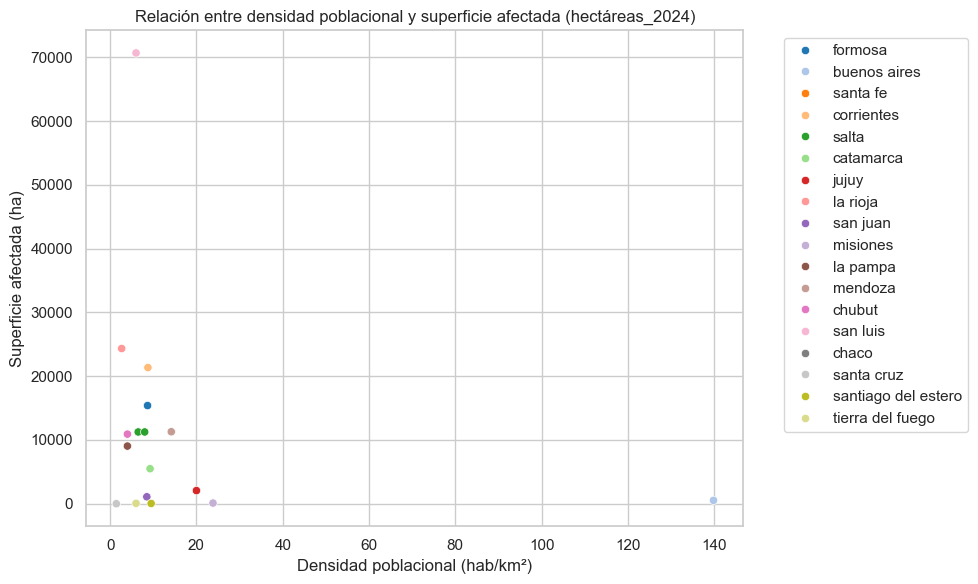

In [7]:
# (Si la columna original se llama 'provincia' en poblacion)
poblacion["jurisdicción"] = poblacion["provincia"].str.strip().str.lower()
superficie_abs["jurisdicción"] = superficie_abs["jurisdicción"].str.strip().str.lower()

df_comb = pd.merge(
    poblacion, 
    superficie_abs[["jurisdicción", superficie_abs.columns[-4]]], 
    on="jurisdicción", 
    how="inner"
)

plt.figure()
sns.scatterplot(data=df_comb, x="prom_densidad_hab_km2", y=superficie_abs.columns[-4], hue="jurisdicción", palette="tab20")
plt.title(f"Relación entre densidad poblacional y superficie afectada ({superficie_abs.columns[-4]})")
plt.xlabel("Densidad poblacional (hab/km²)")
plt.ylabel("Superficie afectada (ha)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Correlaciones profundas
* Se busca entender si hay relación estadística entre:

    🔥 Focos de calor

    🧯 Incendios reportados

    🌾 Superficie afectada

    👥 Densidad poblacional

### Preparacion de la tabla

In [8]:
cols_focos = [c for c in focos.columns if c.startswith("año_") or c.isdigit()]
cols_inc = [c for c in incendios.columns if c.startswith("año_") or c.isdigit()]
cols_sup = [c for c in superficie_abs.columns if c.startswith("hectáreas_") or c.isdigit()]


In [9]:
focos["focos_prom"] = focos[cols_focos].mean(axis=1)
incendios["incendios_prom"] = incendios[cols_inc].mean(axis=1)
superficie_abs = superficie_abs.rename(columns={"promedio": "superficie_afectada_prom"})


### Normalizacion de clave jurisdiccion

In [10]:
# Diccionario para normalizar nombres de jurisdicciones
normalizacion_jurisdicciones = {
    "cordoba": "córdoba",
    "entre rios": "entre ríos",
    "neuquen": "neuquén",
    "rio negro": "río negro",
    "tucuman": "tucumán",
    "stgo. del estero": "santiago del estero",
    "t. del fuego": "tierra del fuego"
}


In [11]:
def normalizar_jurisdicciones(df):
    df["jurisdicción"] = df["jurisdicción"].str.strip().str.lower()
    df["jurisdicción"] = df["jurisdicción"].replace(normalizacion_jurisdicciones)
    return df

# Aplicar a todos los DataFrames
focos = normalizar_jurisdicciones(focos)
incendios = normalizar_jurisdicciones(incendios)
superficie_abs = normalizar_jurisdicciones(superficie_abs)
poblacion = normalizar_jurisdicciones(poblacion)


In [12]:
df_corr = focos[["jurisdicción", "focos_prom"]].merge(
    incendios[["jurisdicción", "incendios_prom"]], on="jurisdicción", how="inner"
).merge(
    superficie_abs[["jurisdicción", "superficie_afectada_prom"]], on="jurisdicción", how="inner"
).merge(
    poblacion[["jurisdicción", "prom_densidad_hab_km2"]], on="jurisdicción", how="left"
)
# Eliminar filas con NaN en variables críticas:
df_corr = df_corr.dropna(subset=["focos_prom", "incendios_prom", "superficie_afectada_prom", "prom_densidad_hab_km2"])


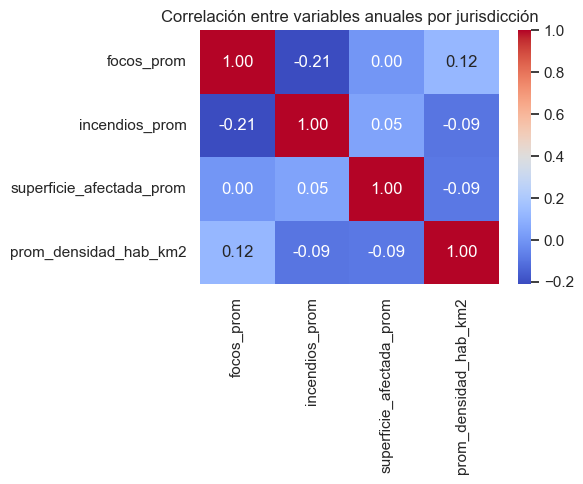

In [13]:
corr_mat = df_corr.drop(columns="jurisdicción").corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación entre variables anuales por jurisdicción")
plt.tight_layout()
plt.show()


In [ ]:
# Melt con columnas ya filtradas por año (definidas antes)
focos_largo = focos.melt(id_vars="jurisdicción", value_vars=cols_focos, var_name="año", value_name="cantidad_focos")
focos_largo["año"] = focos_largo["año"].apply(lambda x: int(re.search(r"\d{4}", x).group()))

incendios_largo = incendios.melt(id_vars="jurisdicción", value_vars=cols_inc, var_name="año", value_name="cantidad_incendios")
incendios_largo["año"] = incendios_largo["año"].apply(lambda x: int(re.search(r"\d{4}", x).group()))

superficie_largo = superficie_abs.melt(id_vars="jurisdicción", value_vars=cols_sup, var_name="año", value_name="superficie_afectada")
superficie_largo["año"] = superficie_largo["año"].apply(lambda x: int(re.search(r"\d{4}", x).group()))


In [15]:
df_ja = focos_largo.merge(incendios_largo, on=["jurisdicción","año"], how="inner") \
                   .merge(superficie_largo, on=["jurisdicción","año"], how="inner") \
                   .merge(poblacion[["jurisdicción","prom_densidad_hab_km2"]], on="jurisdicción", how="left")
df_ja = df_ja.dropna(subset=["cantidad_focos","cantidad_incendios","superficie_afectada","prom_densidad_hab_km2"])


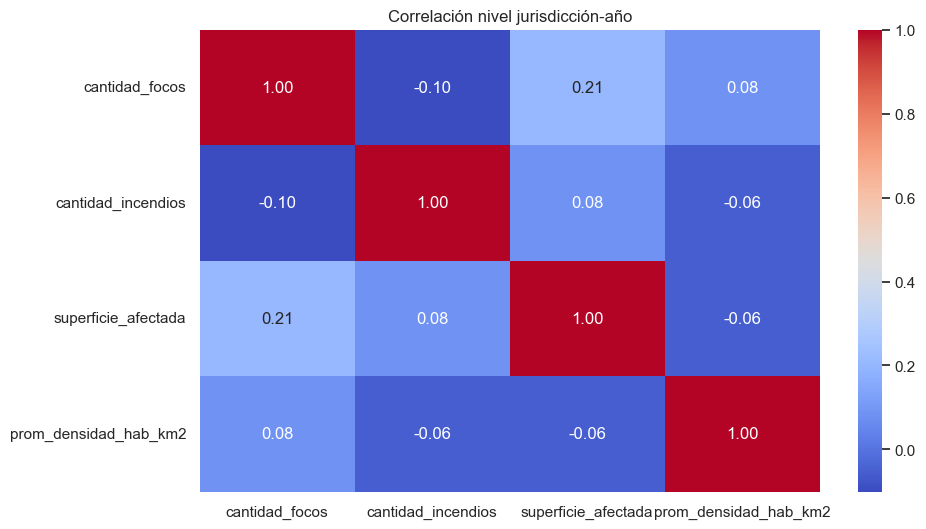

In [17]:
corr_mat2 = df_ja[["cantidad_focos","cantidad_incendios","superficie_afectada","prom_densidad_hab_km2"]].corr()
sns.heatmap(corr_mat2, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación nivel jurisdicción-año")
plt.show()
